<a href="https://colab.research.google.com/github/bhkpriyanka/EVA4/blob/master/Week7/Approach1/S7Step4_Dropout%26IncreasedEpochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
#print(torch.cuda.is_available())
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
print("CUDA current device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(0)) 

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True
CUDA current device: 0
CUDA device name: Tesla P4


In [3]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.RandomRotation((-3.0, 3.0)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     #transforms.RandomRotation((-3.0, 3.0))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])
64
plane   dog  deer  deer


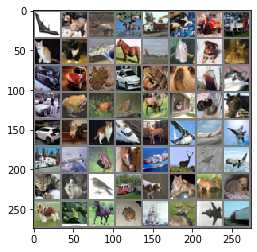

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images[0].shape)
print(len(images))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [5]:
'''import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()'''

'import torch.nn as nn\nimport torch.nn.functional as F\n\n\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 10)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = x.view(-1, 16 * 5 * 5)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n\n\nnet = Net()'

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 32

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1 ,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 32
        '''self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.Dropout(0.01)
        ) # output_size = 2'''
        self.dwsconv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1,groups= 64, bias=False),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = 32

        # TRANSITION BLOCK 1
        self.conv1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

         # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 2\16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 16
        '''self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.Dropout(0.01)
        ) # output_size = 2'''
        self.dwsconv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1,groups= 64, bias=False),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = 16


        # TRANSITION BLOCK 2
        self.conv1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8

        # CONVOLUTION BLOCK 3
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1,dilation=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 8
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = 8


        # TRANSITION BLOCK 3
        self.conv1x1_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8
        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 4

         # CONVOLUTION BLOCK 4
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(0.01)
        ) # output_size = 4

               
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.fcn = nn.Sequential(
            #nn.Linear(in_features=64, out_features=10, bias=False)
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 

        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.dwsconv1(x)
        x = self.conv1x1_1(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.convblock6(x)
        x = self.dwsconv2(x)
        x = self.conv1x1_2(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.conv1x1_3(x)
        x = self.pool3(x)
        x = self.convblock10(x)
        #x = self.convblock11(x)
        
        x = self.gap(x)  

        x = self.fcn(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]             576
           Conv2d-10          [-1, 128, 32, 32]           8,320
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
          Dropout-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    #scheduler.step()
    print('')

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.1861604452133179 Batch_id=781 Accuracy=42.10: 100%|██████████| 782/782 [00:27<00:00, 28.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2919, Accuracy: 5198/10000 (51.98%)


EPOCH: 2


Loss=1.001328706741333 Batch_id=781 Accuracy=58.76: 100%|██████████| 782/782 [00:27<00:00, 28.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1048, Accuracy: 6006/10000 (60.06%)


EPOCH: 3


Loss=1.0589420795440674 Batch_id=781 Accuracy=65.47: 100%|██████████| 782/782 [00:26<00:00, 29.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9028, Accuracy: 6845/10000 (68.45%)


EPOCH: 4


Loss=0.9190222024917603 Batch_id=781 Accuracy=69.57: 100%|██████████| 782/782 [00:27<00:00, 28.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8508, Accuracy: 7034/10000 (70.34%)


EPOCH: 5


Loss=0.892803430557251 Batch_id=781 Accuracy=72.17: 100%|██████████| 782/782 [00:26<00:00, 29.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7700, Accuracy: 7327/10000 (73.27%)


EPOCH: 6


Loss=0.4105657637119293 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:26<00:00, 29.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7803, Accuracy: 7212/10000 (72.12%)


EPOCH: 7


Loss=0.7347368001937866 Batch_id=781 Accuracy=75.73: 100%|██████████| 782/782 [00:26<00:00, 29.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6627, Accuracy: 7666/10000 (76.66%)


EPOCH: 8


Loss=0.8855469226837158 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [00:25<00:00, 30.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6393, Accuracy: 7774/10000 (77.74%)


EPOCH: 9


Loss=0.3541273772716522 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:26<00:00, 29.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6392, Accuracy: 7787/10000 (77.87%)


EPOCH: 10


Loss=1.7536847591400146 Batch_id=781 Accuracy=78.74: 100%|██████████| 782/782 [00:26<00:00, 29.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6706, Accuracy: 7737/10000 (77.37%)


EPOCH: 11


Loss=0.5356900095939636 Batch_id=781 Accuracy=79.48: 100%|██████████| 782/782 [00:26<00:00, 31.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5800, Accuracy: 7983/10000 (79.83%)


EPOCH: 12


Loss=0.4610078036785126 Batch_id=781 Accuracy=80.31: 100%|██████████| 782/782 [00:26<00:00, 29.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5735, Accuracy: 8067/10000 (80.67%)


EPOCH: 13


Loss=0.4945637285709381 Batch_id=781 Accuracy=81.11: 100%|██████████| 782/782 [00:26<00:00, 29.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5734, Accuracy: 8049/10000 (80.49%)


EPOCH: 14


Loss=0.5537509918212891 Batch_id=781 Accuracy=81.50: 100%|██████████| 782/782 [00:26<00:00, 30.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5468, Accuracy: 8134/10000 (81.34%)


EPOCH: 15


Loss=0.6712223291397095 Batch_id=781 Accuracy=81.98: 100%|██████████| 782/782 [00:26<00:00, 31.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5591, Accuracy: 8076/10000 (80.76%)


EPOCH: 16


Loss=0.6152092814445496 Batch_id=781 Accuracy=81.83: 100%|██████████| 782/782 [00:26<00:00, 29.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5602, Accuracy: 8135/10000 (81.35%)


EPOCH: 17


Loss=0.5589620471000671 Batch_id=781 Accuracy=82.74: 100%|██████████| 782/782 [00:26<00:00, 29.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5223, Accuracy: 8218/10000 (82.18%)


EPOCH: 18


Loss=0.43986088037490845 Batch_id=781 Accuracy=83.15: 100%|██████████| 782/782 [00:26<00:00, 29.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5653, Accuracy: 8117/10000 (81.17%)


EPOCH: 19


Loss=0.33764076232910156 Batch_id=781 Accuracy=83.46: 100%|██████████| 782/782 [00:26<00:00, 29.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5646, Accuracy: 8127/10000 (81.27%)


EPOCH: 20


Loss=0.5380005836486816 Batch_id=781 Accuracy=83.73: 100%|██████████| 782/782 [00:26<00:00, 29.85it/s]



Test set: Average loss: 0.5175, Accuracy: 8241/10000 (82.41%)




Text(0.5, 1.0, 'Test Accuracy')

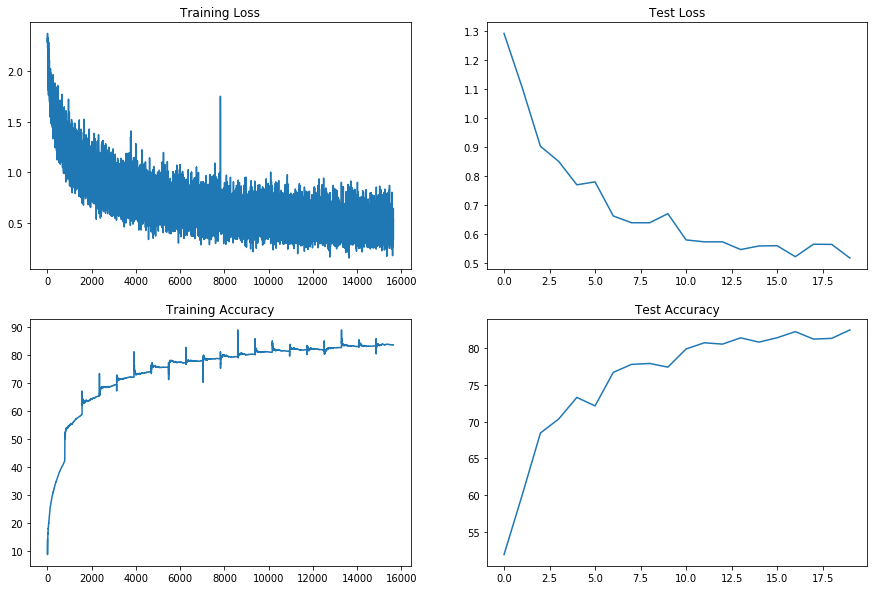

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")